# Marketing Analytics

## Data Description

This data was taken from Kaggle (https://www.kaggle.com/jackdaoud/marketing-data) and was originally part of a final project for Business Analystics Masters students prvided by Dr. Omar Romero-Hernandez.

The data set marketing_data.csv consists of 2,240 customers of XYZ company with data on:
- Customer profiles
- Product preferences
- Campaign successes/failures
- Channel performance

This project will focus on customer profiles as they relate to wine purchases.

There are 28 columns whose descrption is as follows:


## Main Objectives

This analysis will involve dimensionality reduction to isolate customer variables that impact wine sales the most as well as variable engineering to further reduce the number of variables. Once these variables are selected, clustering will be performed to create distinct customer groupings and to determine which groups purchase the most wine. This will enable the business to target groups who are more likely to purchase wine or refine their maketing for groups who do not purchse wine. 

Clustering will invove the use of two different clustering algorithms, which include kmean and agglomerative hierarchical clustering, and the best clustering algorithim will be chosen to make the final groupings.

## Data Cleaning, Exploration and Engineering

In [1]:
# import dataset
import pandas as pd
df = pd.read_csv('marketing_data.csv', sep=',')

In [2]:
# check first 5 rows
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


In [3]:
# check the dimensions of the data frame as well as the column names
print(df.shape)
print(df.columns)

(2240, 28)
Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', ' Income ',
       'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Complain', 'Country'],
      dtype='object')


There are 28 rows which we will need to narrowed down in order for model performance to be improved. Here, we will focus on wine purchases to simplify the research question and remove the columns for other products. We will also remove the 'AcceptedCmp' columns because they do not provide any useful information related to wine purchasing. 

In [4]:
# Lets change Dt_Coustomer (Date of customer's enrollment with the company) to length of time since enrollment with the company.
# We will assume that the dataset was generated on 29Jun14

# convert Dt_Coustomer to datetime
from datetime import datetime

# take datetime entry from 29Jun14
for i in range(len(df.Dt_Customer)):
    df.loc[i,'Dt_Customer'] = datetime(2014, 6, 29) - datetime.strptime(df['Dt_Customer'][i], '%m/%d/%y')
    
for i in range(len(df.Dt_Customer)):
    df.loc[i,'Dt_Customer'] = df['Dt_Customer'][i].days

In [5]:
# lets merge kidhome and teenhome into one column called which represents the count of both children and teens in the household
df['Children'] = df['Kidhome']+df['Teenhome']

In [6]:
# take only columns relevent to wine purchasing
df = df[['Year_Birth', 'Education', 'Marital_Status', ' Income ','Children', 'Dt_Customer', 'Recency', 'MntWines',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Response', 'Complain', 'Country']]

# rename income column bacause it has a gap infront
df = df.rename(columns={' Income ': 'Income'})

In [7]:
# Income is a string with a dollar sign and comma. Lets remove those
df['Income'] = df['Income'].str.replace(r'\D+', '', regex=True)

In [8]:
# look at the data types for each variable
df['Dt_Customer'] = pd.to_numeric(df['Dt_Customer'])
df.dtypes

Year_Birth              int64
Education              object
Marital_Status         object
Income                 object
Children                int64
Dt_Customer             int64
Recency                 int64
MntWines                int64
NumWebPurchases         int64
NumCatalogPurchases     int64
NumStorePurchases       int64
NumWebVisitsMonth       int64
Response                int64
Complain                int64
Country                object
dtype: object

### Check for NANs

In [9]:
# check for NAs
df.isnull().values.any()

True

In [10]:
# How many NAs are there
df.isnull().sum().sum()

24

In [11]:
# Lets get all of the rows with NANs
df[df.isnull().any(axis=1)]

,Year_Birth,Education,Marital_Status,Income,Children,Dt_Customer,Recency,MntWines,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Country
134,1957,PhD,Married,NaN,3,587,4,230,7,2,8,9,0,0,GER
262,1983,Graduation,Married,NaN,1,226,11,5,1,0,2,7,0,0,US
394,1972,PhD,Together,NaN,1,119,17,25,1,0,3,7,0,0,AUS
449,1986,Graduation,Single,NaN,1,494,19,5,27,0,0,1,0,0,AUS
525,1961,PhD,Married,NaN,1,353,23,352,6,1,7,6,0,0,CA
590,1973,2n Cycle,Married,NaN,1,653,25,25,3,0,3,8,0,0,GER
899,1970,Master,Together,NaN,1,454,39,187,4,2,6,5,0,0,US
997,1957,Graduation,Single,NaN,2,33,45,7,1,0,2,7,0,0,GER
1096,1964,2n Cycle,Single,NaN,2,168,49,5,1,0,2,7,0,0,AUS
1185,1969,Master,Together,NaN,2,407,52,375,4,10,4,3,0,0,AUS


It looks like all of the missing values are in the income column. 

In [12]:
# lets delete the NANs
df = df.dropna()
df.isnull().values.any()

False

In [13]:
# lets make income numeric
df['Income'] = df['Income'].astype('float')
df['Income'] = df['Income']/100
df

,Year_Birth,Education,Marital_Status,Income,Children,Dt_Customer,Recency,MntWines,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Country
0,1970,Graduation,Divorced,84835.0,0,13,0,189,4,4,6,1,1,0,SP
1,1961,Graduation,Single,57091.0,0,14,0,464,7,3,7,5,1,0,CA
2,1958,Graduation,Married,67267.0,1,47,0,134,3,2,5,2,0,0,US
3,1967,Graduation,Together,32474.0,2,49,0,10,1,0,2,7,0,0,AUS
4,1989,Graduation,Single,21474.0,1,82,0,6,3,1,2,7,1,0,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1976,PhD,Divorced,66476.0,1,479,99,372,5,2,11,4,0,0,US
2236,1977,2n Cycle,Married,31056.0,1,523,99,5,1,0,3,8,0,0,SP
2237,1976,Graduation,Divorced,46310.0,1,573,99,185,6,1,5,8,0,0,SP
2238,1978,Graduation,Married,65819.0,0,577,99,267,5,4,10,3,0,0,IND


### Check Outliers and Data Distributions

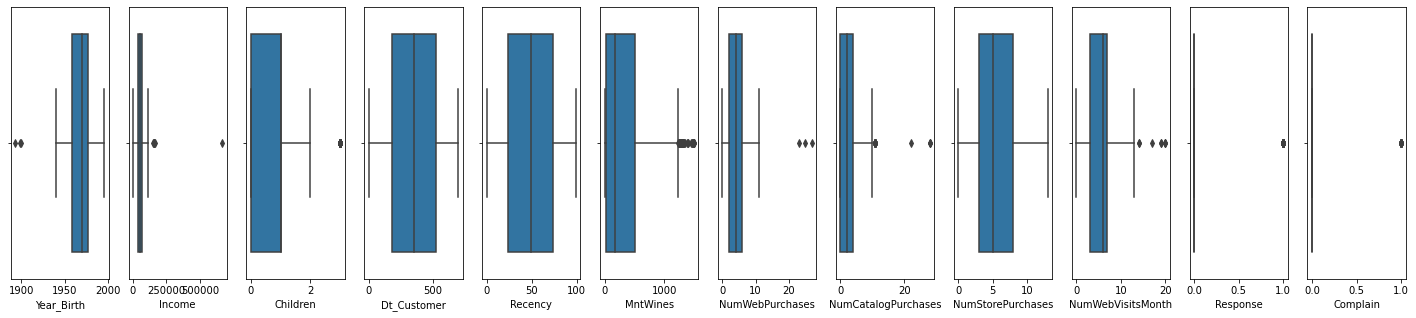

In [14]:
# create boxplots for all numerical columns
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# get a list of numerical columns
num = df.select_dtypes(include=np.number).columns.tolist()

f, axes = plt.subplots(1, len(num),figsize=(25,5))

for i in range(len(num)):
    sns.boxplot(x=df[num[i]], ax=axes[i]);

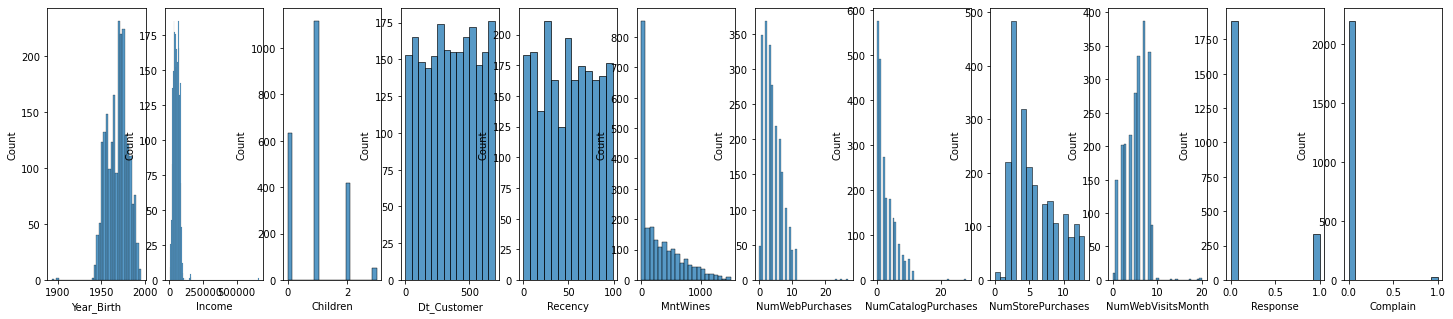

In [15]:
# lets look at the skew for each numerical variable
f, axes = plt.subplots(1, len(num),figsize=(25,5))

for i in range(len(num)):
    sns.histplot(x=df[num[i]], ax=axes[i]);

Some notes:

- Year of birth has some strange outliers towards the year 1900, which look like mistakes because the cutomers would have to be around 100 years old. Without additonal information, these should be discarded.

- Income has some very arge outliers to the right.

- For MntWines, NumWebPurchases, NumCatalogPurchases and NumWebVisitsMonth, the outliers look normal. These will have to be normalised. 

- Responses and complaints are heavily skewed toears no responses of complaints. Will have to make sure to stratify the data to ensure some respondees and complainers make it into the data running through the clustring algorithms. 

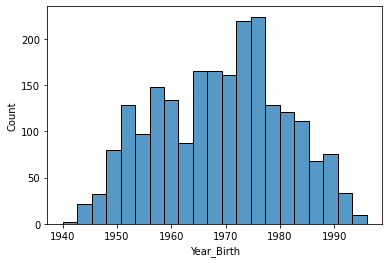

In [16]:
# remove rows with brith year before 1900
df = df[df['Year_Birth'] > 1920]
sns.histplot(x=df['Year_Birth']);

In [17]:
# lets change year of birth to age and drop year of birth
df['Age'] = 2014 - df.loc[:,'Year_Birth']
df = df.drop('Year_Birth',axis=1);

/tmp/ipykernel_103282/4272982572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age'] = 2014 - df.loc[:,'Year_Birth']


In [18]:
df[df['NumWebPurchases'] > 20]

,Education,Marital_Status,Income,Children,Dt_Customer,Recency,MntWines,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Country,Age
14,Graduation,Married,4428.0,1,267,0,16,25,0,0,1,0,0,SP,45
210,PhD,Single,113734.0,0,32,9,6,27,0,0,1,0,0,SP,69
2063,PhD,Single,7144.0,2,204,92,81,23,1,1,0,0,0,SP,48


In [19]:
df['Income'].sort_values(ascending=False).head()
# looks like there is a type (666666). Will remove this.

527     666666.0
731     162397.0
497     160803.0
853     157733.0
2204    157243.0
Name: Income, dtype: float64

In [20]:
# remove income value 666666
df = df[df['Income'] < 150000.0]

In [21]:
# lets look at median income per education level
df[['Income','Education']].groupby(by='Education').median()

,Income
Education,
2n Cycle,46805.0
Basic,20744.0
Graduation,51948.0
Master,50920.5
PhD,55005.0


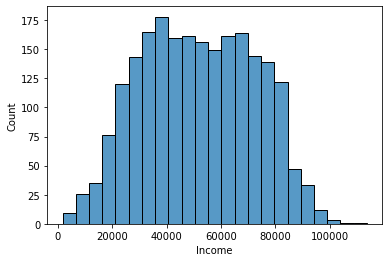

In [22]:
sns.histplot(x=df['Income']); # this look better

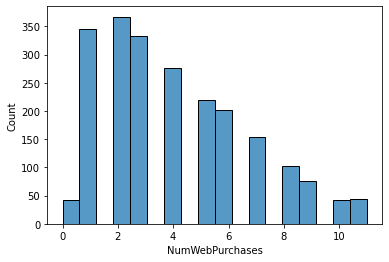

In [23]:
# lets normalise  MntWines, NumWebPurchases, NumCatalogPurchases and NumWebVisitsMonth
df = df[df['NumWebPurchases'] < 20]
sns.histplot(x=df['NumWebPurchases']);

In [24]:
df[df['NumCatalogPurchases'] > 20]

,Education,Marital_Status,Income,Children,Dt_Customer,Recency,MntWines,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Country,Age
961,Graduation,Married,2447.0,1,539,42,1,0,28,0,1,0,0,US,35


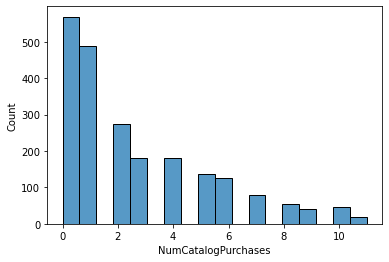

In [25]:
df = df[df['NumCatalogPurchases'] < 20]
sns.histplot(x=df['NumCatalogPurchases']);

In [26]:
df[df['NumWebVisitsMonth'] > 12]

,Education,Marital_Status,Income,Children,Dt_Customer,Recency,MntWines,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Country,Age
60,Master,Single,6560.0,0,199,2,67,1,0,1,17,0,0,SP,32
299,Graduation,Married,5305.0,1,334,12,12,1,0,0,13,0,0,IND,38
456,Graduation,Divorced,4861.0,0,7,20,2,0,0,0,14,0,0,SA,49
663,PhD,Married,4023.0,2,6,29,5,0,0,0,19,0,0,SP,51
1291,Graduation,Single,3502.0,1,442,56,2,0,0,0,14,0,0,IND,41
1416,Graduation,Single,8028.0,0,649,62,73,0,1,0,19,0,0,SP,23
1466,Graduation,Divorced,1730.0,0,42,65,1,0,0,0,20,0,0,SP,43
1533,PhD,Together,5648.0,2,108,68,28,1,0,0,20,0,0,US,64
1721,PhD,Together,6835.0,1,568,76,107,0,0,1,20,0,0,CA,57


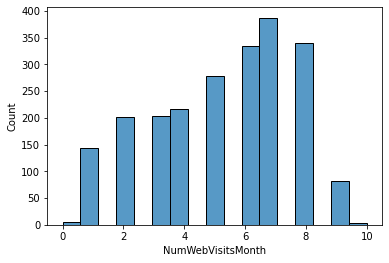

In [27]:
df = df[df['NumWebVisitsMonth'] < 12]
sns.histplot(x=df['NumWebVisitsMonth']);

## Dimensionality Reduction

In [28]:
# check for correations 
corr_mat = df.corr()

# Strip the diagonal for future examination
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,Income,Children,Dt_Customer,Recency,MntWines,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age
Income,0.000000,-0.355955,-0.027906,0.006352,0.734919,0.524029,0.738328,0.685445,-0.654105,0.173148,-0.029000,0.212647
Children,-0.355955,0.000000,-0.026167,0.016081,-0.358487,-0.161125,-0.467890,-0.334283,0.447112,-0.169946,0.032115,0.091648
Dt_Customer,-0.027906,-0.026167,0.000000,0.025816,0.166597,0.211336,0.092357,0.108664,0.304165,0.196278,0.035782,-0.009791
Recency,0.006352,0.016081,0.025816,0.000000,0.014917,0.000391,0.029713,-0.002631,-0.018890,-0.201885,0.005620,0.014023
MntWines,0.734919,-0.358487,0.166597,0.014917,0.000000,0.583228,0.688845,0.637915,-0.336156,0.244137,-0.037248,0.165662
NumWebPurchases,0.524029,-0.161125,0.211336,0.000391,0.583228,0.000000,0.460851,0.548468,-0.016349,0.158719,-0.014261,0.160076
NumCatalogPurchases,0.738328,-0.467890,0.092357,0.029713,0.688845,0.460851,0.000000,0.577507,-0.550009,0.239379,-0.019118,0.148829
NumStorePurchases,0.685445,-0.334283,0.108664,-0.002631,0.637915,0.548468,0.577507,0.000000,-0.450130,0.029471,-0.013605,0.140918
NumWebVisitsMonth,-0.654105,0.447112,0.304165,-0.018890,-0.336156,-0.016349,-0.550009,-0.450130,0.000000,0.001900,0.023321,-0.129296
Response,0.173148,-0.169946,0.196278,-0.201885,0.244137,0.158719,0.239379,0.029471,0.001900,0.000000,-0.000512,-0.021242


In [29]:
corr_mat.abs().idxmax()

Income                 NumCatalogPurchases
Children               NumCatalogPurchases
Dt_Customer              NumWebVisitsMonth
Recency                           Response
MntWines                            Income
NumWebPurchases                   MntWines
NumCatalogPurchases                 Income
NumStorePurchases                   Income
NumWebVisitsMonth                   Income
Response                          MntWines
Complain                          MntWines
Age                                 Income
dtype: object

In [30]:
# Examine skew
num_col = df.drop(columns=['Education', 'Marital_Status','Response','Complain','Country'])
log_columns = num_col.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

MntWines               1.159377
NumCatalogPurchases    1.097109
dtype: float64

In [31]:
# Log transform heavily skewed numerical variables
for col in log_columns.index:
    df[col] = np.log1p(df[col])

In [32]:
# change all object variables into numerical
df[['Edu_num','Mar_num','Cou_num']] = df[['Education','Marital_Status','Country']].apply(lambda x: x.astype('category'))

cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [33]:
# lets scale the data so that it can be used for PCA
# we are going to use the robust scaler because we have several columns that are either 0 or 1, which will impact explained variance
from sklearn.preprocessing import RobustScaler

scaled_df = df.select_dtypes(include=np.number)

scaler = RobustScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
scaled_df.head()

,Income,Children,Dt_Customer,Recency,MntWines,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Edu_num,Mar_num,Cou_num
0,1.018584,-1.0,-0.984925,-0.98,0.016103,0.00,0.317394,0.2,-1.25,1.0,0.0,0.000000,0.0,-1.0,0.000000
1,0.173361,-1.0,-0.982053,-0.98,0.313097,0.75,0.178747,0.4,-0.25,1.0,0.0,0.500000,0.0,0.0,-1.666667
2,0.483374,0.0,-0.887294,-0.98,-0.097301,-0.25,0.000000,0.0,-1.00,0.0,0.0,0.666667,0.0,-0.5,0.333333
3,-0.576597,1.0,-0.881551,-0.98,-0.929330,-0.75,-0.682606,-0.6,0.25,0.0,0.0,0.166667,0.0,0.5,-2.000000
4,-0.911712,0.0,-0.786791,-0.98,-1.079313,-0.25,-0.251930,-0.6,0.25,1.0,0.0,-1.055556,0.0,0.0,0.000000


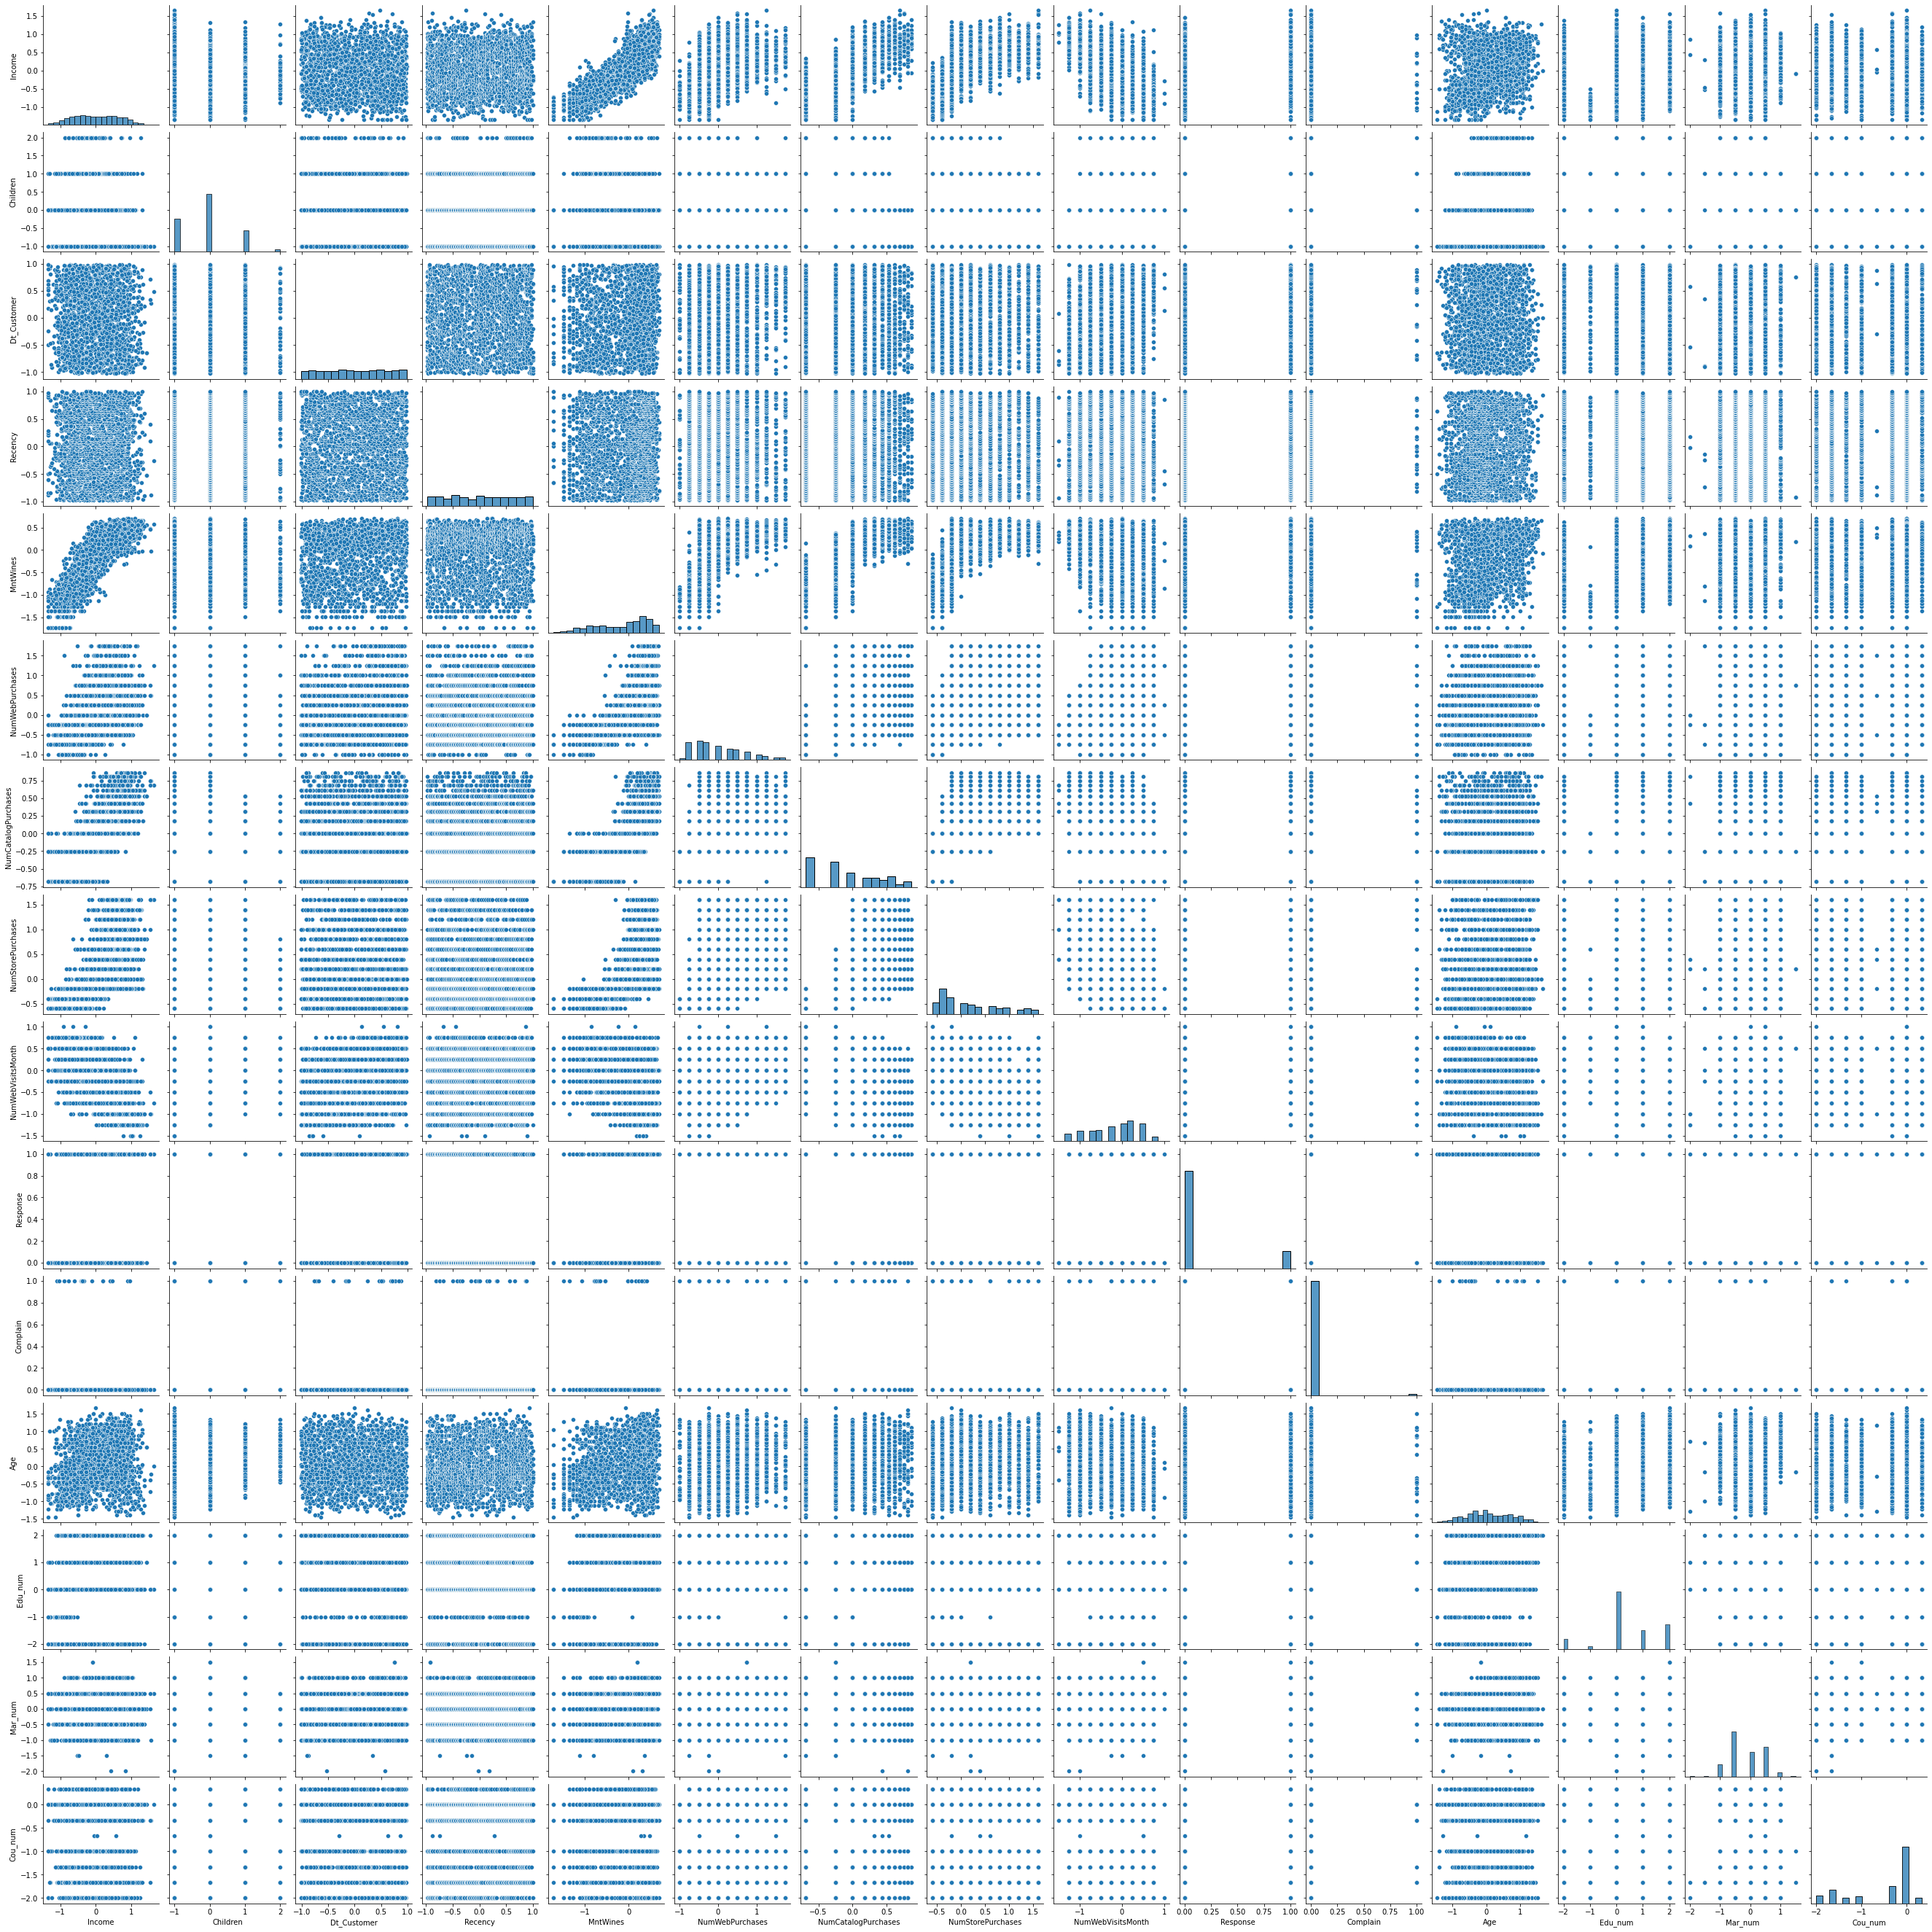

In [34]:
# lets look at a pair plot
sns.pairplot(scaled_df);

### Feature Selection with PCA

In [35]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 10):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(scaled_df)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': scaled_df.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.279016
2,PCA(n_components=2),0.481038
3,PCA(n_components=3),0.575932
4,PCA(n_components=4),0.664618
5,PCA(n_components=5),0.739526
6,PCA(n_components=6),0.795938
7,PCA(n_components=7),0.850463
8,PCA(n_components=8),0.897085
9,PCA(n_components=9),0.932721


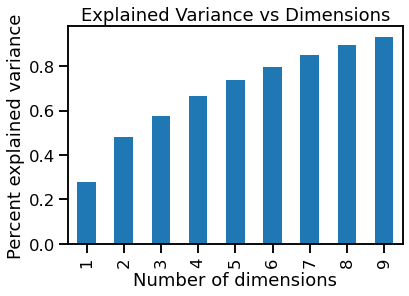

In [36]:
sns.set_context('talk')
ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

In [37]:
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

features_df

features,Age,Children,Complain,Cou_num,Dt_Customer,Edu_num,Income,Mar_num,MntWines,NumCatalogPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Response
n,,,,,,,,,,,,,,,
1,0.051747,0.083128,0.001044,0.003045,0.008356,0.143396,0.136233,0.003067,0.137670,0.099311,0.126202,0.107779,0.080641,0.000032,0.018348
2,0.045385,0.101002,0.000928,0.005774,0.014475,0.248690,0.110363,0.002281,0.098969,0.086489,0.110304,0.088142,0.074222,0.001554,0.011422
3,0.065082,0.140529,0.001084,0.025496,0.055002,0.181636,0.074225,0.002522,0.087635,0.058382,0.084411,0.114010,0.098144,0.003339,0.008502
4,0.058232,0.117522,0.001389,0.120549,0.062985,0.151472,0.065301,0.005756,0.076043,0.048377,0.072748,0.102724,0.094744,0.012684,0.009474
5,0.093736,0.120473,0.001186,0.105928,0.087027,0.129361,0.062951,0.011190,0.059593,0.037749,0.056743,0.094999,0.098500,0.020444,0.020120
6,0.092563,0.108672,0.001063,0.101717,0.083164,0.117416,0.056719,0.011811,0.052871,0.034740,0.051010,0.084787,0.087820,0.086377,0.029270
7,0.113760,0.118280,0.001018,0.088678,0.093580,0.098846,0.057444,0.035330,0.050178,0.029458,0.052983,0.078199,0.078296,0.074474,0.029477
8,0.119944,0.116194,0.000967,0.080786,0.091228,0.089071,0.054176,0.079548,0.047525,0.026677,0.050807,0.073702,0.071093,0.070060,0.028221
9,0.110604,0.117090,0.001137,0.071604,0.107840,0.078660,0.056178,0.070436,0.042738,0.027298,0.054634,0.092404,0.078047,0.064644,0.026687


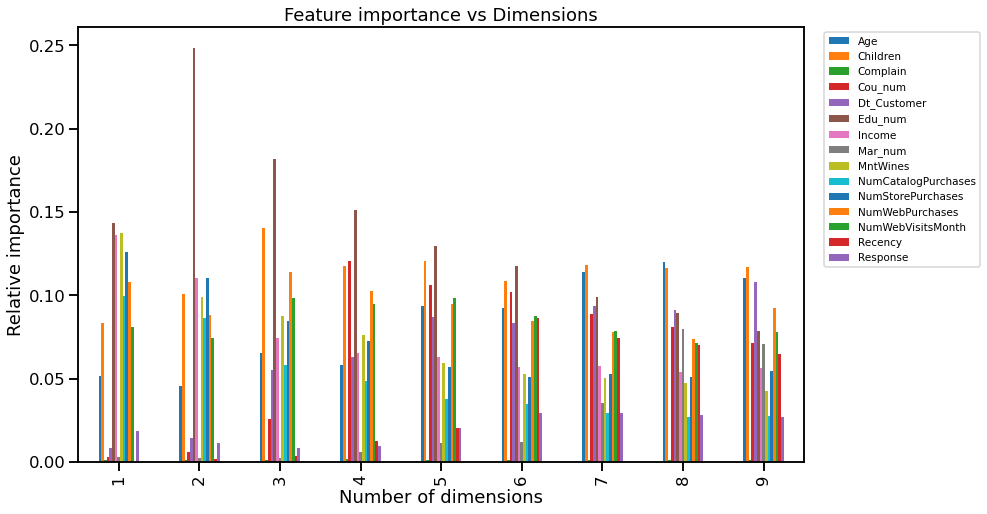

In [38]:
ax = features_df.plot(kind='bar', figsize=(13,8))
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1), fontsize='xx-small')
ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');

In [39]:
# get variables that explain the majority of the variance in the data 
l = []
for i in range(len(features_df.columns)):
    if features_df.iloc[:,i].max() > 0.1:
        l.append(features_df.columns[i])

l

['Age',
 'Children',
 'Cou_num',
 'Dt_Customer',
 'Edu_num',
 'Income',
 'MntWines',
 'NumStorePurchases',
 'NumWebPurchases']

In [40]:
model_data = scaled_df[l]
model_data.head()

,Age,Children,Cou_num,Dt_Customer,Edu_num,Income,MntWines,NumStorePurchases,NumWebPurchases
0,0.000000,-1.0,0.000000,-0.984925,0.0,1.018584,0.016103,0.2,0.00
1,0.500000,-1.0,-1.666667,-0.982053,0.0,0.173361,0.313097,0.4,0.75
2,0.666667,0.0,0.333333,-0.887294,0.0,0.483374,-0.097301,0.0,-0.25
3,0.166667,1.0,-2.000000,-0.881551,0.0,-0.576597,-0.929330,-0.6,-0.75
4,-1.055556,0.0,0.000000,-0.786791,0.0,-0.911712,-1.079313,-0.6,-0.25


## Clustering

### K-means

In [41]:
from sklearn.cluster import KMeans

km_list = list()

for clust in range(1,21):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(model_data)
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

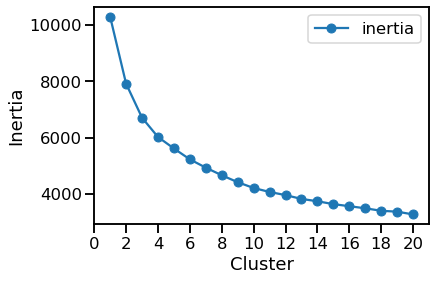

In [42]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');
### END SOLUTION

Although the elbow of the graph isunclear, K-mean = 5 seems to be an okay choice and will implement that

In [43]:
# use k-mean = 5
km = KMeans(n_clusters=5, random_state=42)
km = km.fit(model_data)

df['kmeans'] = km.predict(model_data)

In [44]:
df[l].columns

Index(['Age', 'Children', 'Cou_num', 'Dt_Customer', 'Edu_num', 'Income',
       'MntWines', 'NumStorePurchases', 'NumWebPurchases'],
      dtype='object')

In [45]:
data = df[['kmeans','Children','Country','Dt_Customer','Education','Income','MntWines','NumStorePurchases','NumWebPurchases','Age']]
data.head()

,kmeans,Children,Country,Dt_Customer,Education,Income,MntWines,NumStorePurchases,NumWebPurchases,Age
0,0,0,SP,13,Graduation,84835.0,5.247024,6,4,44
1,0,0,CA,14,Graduation,57091.0,6.142037,7,7,53
2,0,1,US,47,Graduation,67267.0,4.905275,5,3,56
3,1,2,AUS,49,Graduation,32474.0,2.397895,2,1,47
4,1,1,SP,82,Graduation,21474.0,1.945910,2,3,25


In [46]:
# lets create a table that groups the data by clusters and provides the mean of each variable in the cluster
table = data.groupby(by='kmeans').median().round()

In [47]:
# lets add the most common level of education for each cluster to the table
table['Education'] = 'NA'

for i in range(len(table)):
    edu = data[data['kmeans']==i].groupby('Education').count().sort_values('kmeans', ascending=False).index.tolist()
    edu = ', '.join(edu)
    table.loc[i,'Education'] = edu

In [48]:
# Lets add in the three most predominant countries for each cluster and their percentage in brackets.
for x in range(len(table)):
    l=[]
    row = data[data['kmeans']==x].groupby('Country').count().sort_values('kmeans', ascending=False)['kmeans']
    row = round((row/sum(row))*100)
    row_names = row.head(3).index.tolist()
    for i in range(len(row_names)):
        r = row_names[i] + ' (' + str(round((row/sum(row))*100)[i]) + ')'
        l.append(r)
    l = ', '.join(l)
    table.loc[x,'Country'] = l

In [49]:
table.sort_values('Income', ascending=False)

,Children,Dt_Customer,Income,MntWines,NumStorePurchases,NumWebPurchases,Age,Education,Country
kmeans,,,,,,,,,
0,1.0,390.0,68655.0,6.0,8.0,6.0,47.0,"Graduation, 2n Cycle, Basic","SP (49.0), SA (15.0), CA (12.0)"
2,1.0,403.0,66582.0,6.0,8.0,6.0,49.0,"PhD, Master","SP (49.0), SA (16.0), CA (14.0)"
3,2.0,264.0,40748.0,4.0,3.0,2.0,47.0,"PhD, Master","SP (50.0), SA (20.0), CA (10.0)"
1,1.0,338.0,33955.0,3.0,3.0,2.0,40.0,"Graduation, Master","SP (51.0), SA (14.0), CA (11.0)"
4,1.0,362.0,26907.0,2.0,3.0,2.0,36.0,"2n Cycle, Basic","SP (48.0), SA (13.0), CA (12.0)"


K-means grouped the data into 5 clusters. 

- Cluster 0: High Income, big wine consumer, big purchaser, moderatly educated
- Cluster 1: Low Income, low wine consumer, low purchaser, moderatly educated
- Cluster 2: High Income, big wine consumer, big purchaser, highly educated
- Cluster 3: Moderate Income, moderate wine consumer, low purchaser, highly educated
- Cluster 4: Low Income, low wine consumer, low puchaser, lower education

### Agglomerative hierarchical Clustering

In [52]:
from sklearn.cluster import AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(model_data)
df['agg'] = ag.fit_predict(model_data)

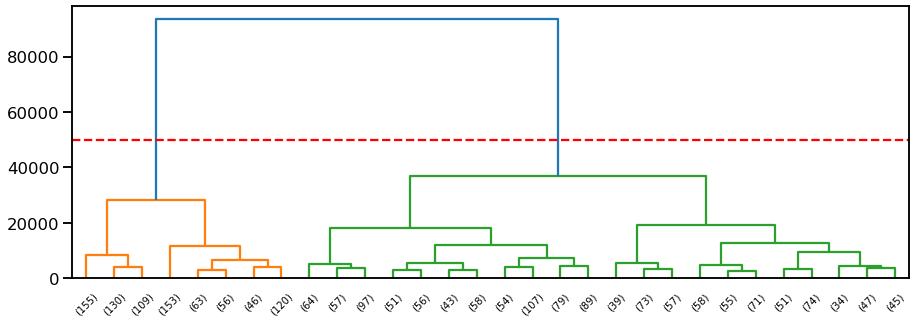

In [53]:
# First, we import the cluster hierarchy module from SciPy (described above) to obtain the linkage and dendrogram functions.
from scipy.cluster import hierarchy

Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))

den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax)

plt.axhline(y=50000, color='r', linestyle='--');

Basically the horizontal line is a threshold that defines the minimum distance required to be a separate cluster. If we draw a horizontal line that passes through longest distance without a horizontal line, we get 2 clusters. Now we know the number of clusters for our dataset, the next step is to group the data points into these 2 clusters. 

In [54]:
# lets create a table that groups the data by clusters and provides the mean of each variable in the cluster
data = df[['agg','Children','Country','Dt_Customer','Education','Income','MntWines','NumStorePurchases','NumWebPurchases','Age']]
table_agglom = data.groupby(by='agg').median().round()

In [55]:
# lets add the most common level of education for each cluster to the table
table_agglom['Education'] = 'NA'

for i in range(len(table_agglom)):
    edu = data[data['agg']==i].groupby('Education').count().sort_values('agg', ascending=False).index.tolist()
    edu = ', '.join(edu)
    table_agglom.loc[i,'Education'] = edu

In [57]:
# Lets add in the three most predominant countries for each cluster and their percentage in brackets.
for x in range(len(table_agglom)):
    l=[]
    row = data[data['agg']==x].groupby('Country').count().sort_values('agg', ascending=False)['agg']
    row = round((row/sum(row))*100)
    row_names = row.head(3).index.tolist()
    for i in range(len(row_names)):
        r = row_names[i] + ' (' + str(round((row/sum(row))*100)[i]) + ')'
        l.append(r)
    l = ', '.join(l)
    table_agglom.loc[x,'Country'] = l

In [58]:
table_agglom

,Children,Dt_Customer,Income,MntWines,NumStorePurchases,NumWebPurchases,Age,Education,Country
agg,,,,,,,,,
0,1.0,384.0,65463.0,6.0,7.0,5.0,47.0,"Graduation, PhD, Master, 2n Cycle, Basic","SP (49.0), SA (16.0), CA (12.0)"
1,1.0,322.0,33462.0,3.0,3.0,2.0,41.0,"Graduation, PhD, Master, 2n Cycle, Basic","SP (51.0), SA (14.0), CA (12.0)"


Agglomerative hierachical clustering split the data into 2 clusters. The clusters are as follows:

- Cluster 0: Higher earner, high purchaser, high wine purchaser overall
- Cluster 1: Low earner, low wine purchaser, low purchaser overall

## Model Recommendations and Key Fndings

#### Comparing K-means and agglomerative clustering

In [69]:
(df[['agg','kmeans']]
 .groupby(['agg','kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
agg kmeans        
0   0          661
    1          101
    2          443
    3           51
    4           33
1   0            5
    1          474
    2           10
    3          255
    4          159

In [70]:
table # K-means groupings

,Children,Dt_Customer,Income,MntWines,NumStorePurchases,NumWebPurchases,Age,Education,Country
kmeans,,,,,,,,,
0,1.0,390.0,68655.0,6.0,8.0,6.0,47.0,"Graduation, 2n Cycle, Basic","SP (49.0), SA (15.0), CA (12.0)"
1,1.0,338.0,33955.0,3.0,3.0,2.0,40.0,"Graduation, Master","SP (51.0), SA (14.0), CA (11.0)"
2,1.0,403.0,66582.0,6.0,8.0,6.0,49.0,"PhD, Master","SP (49.0), SA (16.0), CA (14.0)"
3,2.0,264.0,40748.0,4.0,3.0,2.0,47.0,"PhD, Master","SP (50.0), SA (20.0), CA (10.0)"
4,1.0,362.0,26907.0,2.0,3.0,2.0,36.0,"2n Cycle, Basic","SP (48.0), SA (13.0), CA (12.0)"


In [72]:
table_agglom # agglomeratve hierachical groupings

,Children,Dt_Customer,Income,MntWines,NumStorePurchases,NumWebPurchases,Age,Education,Country
agg,,,,,,,,,
0,1.0,384.0,65463.0,6.0,7.0,5.0,47.0,"Graduation, PhD, Master, 2n Cycle, Basic","SP (49.0), SA (16.0), CA (12.0)"
1,1.0,322.0,33462.0,3.0,3.0,2.0,41.0,"Graduation, PhD, Master, 2n Cycle, Basic","SP (51.0), SA (14.0), CA (12.0)"


After conducting feature selection using PCA, the variables 'Age', 'Children', 'Cou_num', 'Dt_Customer', 'Edu_num', 'Income', 'MntWines', 'NumStorePurchases' and 'NumWebPurchases' were identified as explaining the most variance in the dataset and were used to find customer groupings. The feature selection and data cleaning narrowed down 28 variables to only 9. 

It appears that cluster 0 in agglomerative hierarchical is comprised of clusters 0 and 2 in k-means. Cluster 0 in agglomerative hierarchical appear to be high eraners and high consumers. Clusters 0 and 2 in k-means are also high earners, high purchasers and are only distiguished by their level of education where 2 appears to be comprised of higher educated customers than 0 on average. 

Cluster 1 in agglomerative hierarchical apears to be comprised of clusters 1, 3 and 4 in kmeans. Cluster 1 in agglomerative hierarchical appear to be medium to low income earners who are low purchases of both wine and general. In K-means, the clusters are distinguished based on earnings and education where cluster 1 are predominantly graduates, cluster 3 are PhDs and cluster 4 are basic educated. 

It appears that the most practical clustering of customers is that produced by agglomerative hierarchical clustering. Splitting the customer base into 2 groups appears to be more practical because 1) it is replicated in K-means, which also split the customer base based on earings and 2) customer earnings appear to be directly related to the degree of purchasing where high earners are high purchasers and lower earners tend to be low puchasers regardless of their education level. These results suggest that earnings play an important role in whether a customer is likely to puchase more and, in particular, purchase more wine. 

The business can look into identifying ways to increase purchasing among its low income customers or increase purchasing in its high income customers with more targeted advertising. 

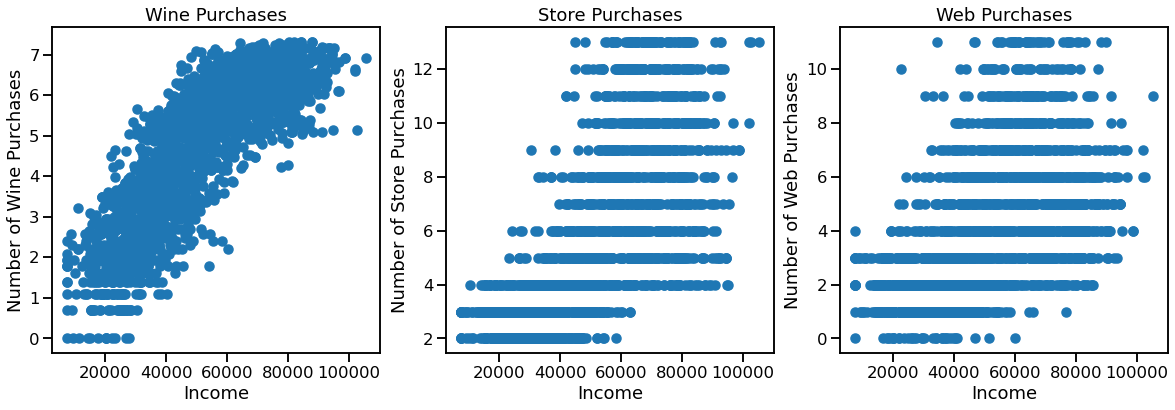

In [92]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

ax[0].scatter(df['Income'], df['MntWines'])
ax[0].title.set_text('Wine Purchases')
ax[0].set(xlabel='Income', ylabel='Number of Wine Purchases')

ax[1].scatter(df['Income'], df['NumStorePurchases'])
ax[1].title.set_text('Store Purchases')
ax[1].set(xlabel='Income', ylabel='Number of Store Purchases')

ax[2].scatter(df['Income'], df['NumWebPurchases'])
ax[2].title.set_text('Web Purchases')
ax[2].set(xlabel='Income', ylabel='Number of Web Purchases');

## Next Steps

The next steps would be to build a supervised machine learning model that can predict whether a customer is a low or high wine purchaser based on their income. The business could send targeted advertisment to these different groups in an attempt to increase purchasing. It would be interesting to look into other products provided by this business as well to see if any of the other variable have more of an impact. 